## Fukuro Omnivision Modeling 
by Marco Aland Adinanda

### A. Introduction

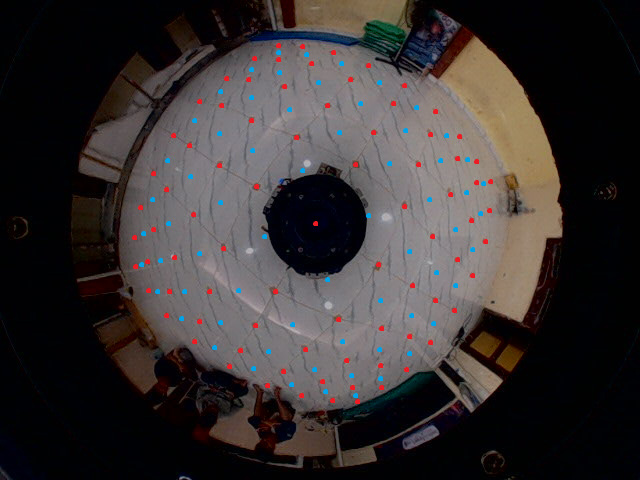

- Training data: Red dot
- Testing data: Blue dot

### B. Importing and Visualize Dataset

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
train_path = "dataset/training_set.csv"
test_path = "dataset/testing_set.csv"

data_train = pd.read_csv(train_path, delimiter=";")
data_train['distance'] = np.sqrt(data_train['field_x']**2 + data_train['field_y']**2)

data_test_val = pd.read_csv(test_path, delimiter=";")
data_test_val['distance'] = np.sqrt(data_test_val['field_x']**2 + data_test_val['field_y']**2)

data_train.head()

,pixel_x,pixel_y,field_x,field_y,distance
0,278,45,-200,-200,282.842712
1,303,46,-150,-200,250.000000
2,334,52,-100,-200,223.606798
3,369,67,-50,-200,206.155281
4,406,85,0,-200,200.000000


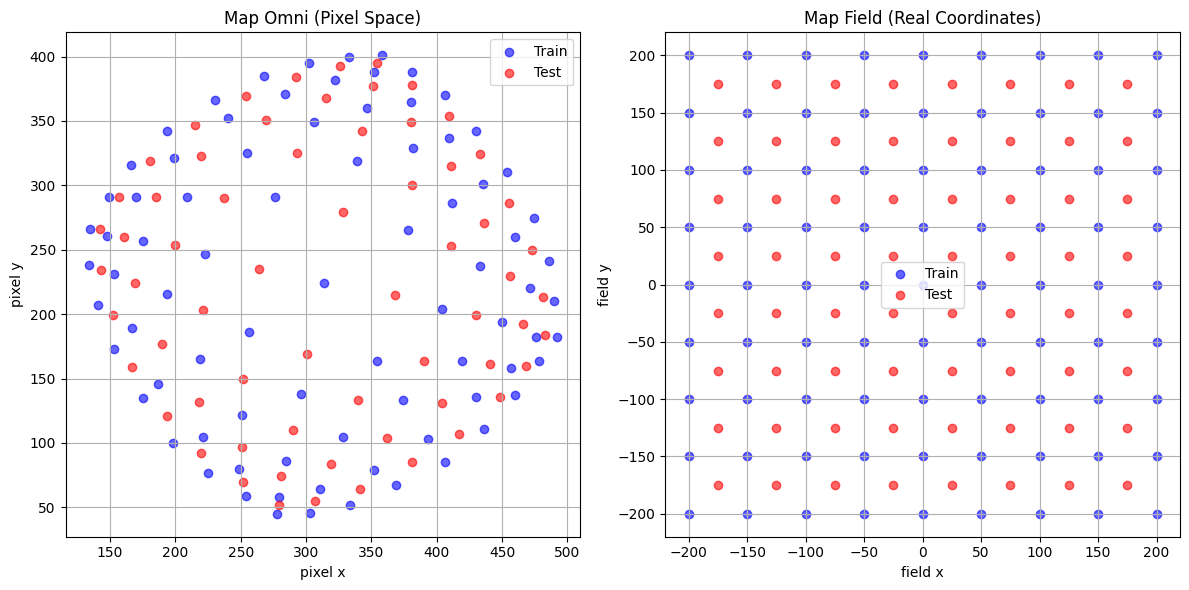

In [2]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title("Map Omni (Pixel Space)")
ax1.set_xlabel("pixel x")
ax1.set_ylabel("pixel y")

# Train points
ax1.scatter(data_train['pixel_x'], data_train['pixel_y'], c='blue', label='Train', alpha=0.6)
# Test points
ax1.scatter(data_test_val['pixel_x'], data_test_val['pixel_y'], c='red', label='Test', alpha=0.6)

ax1.legend()
ax1.grid(True)

ax2.set_title("Map Field (Real Coordinates)")
ax2.set_xlabel("field x")
ax2.set_ylabel("field y")

# Train points
ax2.scatter(data_train['field_x'], data_train['field_y'], c='blue', label='Train', alpha=0.6)
# Test points
ax2.scatter(data_test_val['field_x'], data_test_val['field_y'], c='red', label='Test', alpha=0.6)

ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


### C. Model Building

#### 1. Dataset Preparation

In [3]:
from sklearn.model_selection import train_test_split

X_train = data_train[['pixel_x', 'pixel_y']].values
y_train = data_train['distance'].values

X_test_val = data_test_val[['pixel_x', 'pixel_y']].values
y_test_val = data_test_val['distance'].values

X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.3, random_state=42)

# Train, Test, Val size
print(f"Train set: {X_train.shape[0]}")
print(f"Test set: {X_test.shape[0]}")
print(f"Val set: {X_val.shape[0]}")

Train set: 81
Test set: 44
Val set: 20


#### 2. SVR with RBF Kernel 

In [4]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, reciprocal
import numpy as np

param_distributions = {
    'C': reciprocal(0.1, 1000),             
    'epsilon': uniform(0.01, 5),           
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf']                      
}

random_search = RandomizedSearchCV(
    SVR(),
    param_distributions,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

svr_model = random_search.best_estimator_
svr_model

Fitting 5 folds for each of 50 candidates, totalling 250 fits


SVR(C=728.6653737491035, epsilon=4.051986740582305)

#### 3. Gausian Regression

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

kernel_list = [C(1.0) * RBF(length_scale=l) for l in np.logspace(-2, 2, 10)]

mae_scorer = make_scorer(mean_squared_error, greater_is_better=False) 

gpr = GaussianProcessRegressor(n_restarts_optimizer=20, alpha=1e-6)

grid_search = GridSearchCV(
    estimator=gpr,
    param_grid={"kernel": kernel_list},
    scoring=mae_scorer,
    cv=5,  
    verbose=1,
    n_jobs=-1  
)

grid_search.fit(X_train, y_train)

gaussian_model = grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


#### 4. Model Selection

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_val, y_val, model_name="Model"):
    y_pred = model.predict(X_val)
    
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"Mean Squared Error (MSE):  {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error:   {rmse:.4f}")
    print(f"R² Score:                   {r2:.4f}")
    print()
    
    return {
        "mse": mse,
        "mae": mae,
        "rmse": rmse,
        "r2": r2
    }

svr_scores = evaluate_model(svr_model, X_val, y_val, model_name="SVR")
gpr_scores = evaluate_model(gaussian_model, X_val, y_val, model_name="Gaussian Process")

--- SVR Evaluation ---
Mean Squared Error (MSE):  39.9002
Mean Absolute Error (MAE): 5.3865
Root Mean Squared Error:   6.3167
R² Score:                   0.9858

--- Gaussian Process Evaluation ---
Mean Squared Error (MSE):  64.6736
Mean Absolute Error (MAE): 5.9769
Root Mean Squared Error:   8.0420
R² Score:                   0.9770



In [11]:
# plot model prediction curve
import plotly.graph_objects as go

def plot_prediction_curve(model, X_test, y_test, title=""):
    x_range = np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 100)
    y_range = np.linspace(X_test[:, 1].min(), X_test[:, 1].max(), 100)
    xx, yy = np.meshgrid(x_range, y_range)

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    zz_pred = model.predict(grid_points).reshape(xx.shape)

    fig = go.Figure()

    fig.add_trace(go.Surface(
        x=xx, y=yy, z=zz_pred,
        colorscale='Viridis',
        opacity=0.8,
        name='Predicted Surface'
    ))

    fig.add_trace(go.Scatter3d(
        x=X_test[:, 0],
        y=X_test[:, 1],
        z=y_test,
        mode='markers',
        marker=dict(size=3, color='red'),
        name='Actual Points'
    ))

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='Pixel X',
            yaxis_title='Pixel Y',
            zaxis_title='Distance'
        ),
        height=800
    )

    fig.show()

In [8]:
plot_prediction_curve(svr_model, X_test, y_test, title="SVR Prediction Plot")

In [9]:
plot_prediction_curve(gaussian_model, X_test, y_test, title="Gaussian Prediction Plot")

### D. Model Evaluation

Based on the previous section, we know that SVR model with RBF Kernel tends to be more generalize than gaussian model. Thus, we're going to use SVR as our main prediction model

In [17]:
# Manual check
def predict_distance(model, pixel_x, pixel_y):
    input_data = np.array([[pixel_x, pixel_y]])
    predicted_distance = model.predict(input_data)
    return predicted_distance[0]

# Define testing variable
test_x, test_y = 479, 231
true_value = 201.556

# Predict the distance
test_pred = predict_distance(svr_model, test_x, test_y)
print(f"Predicted Distance: {test_pred:.3f} cm")
print(f"Error: {abs(true_value - test_pred):.3f} cm")

Predicted Distance: 205.364 cm
Error: 3.808 cm


In [19]:
# Save the best model
import pickle

with open("models/best_model.pkl", "wb") as file:
    pickle.dump(svr_model, file)
print("Model saved successfully!")

Model saved successfully!


### E. Load and Self Input Test

In [20]:
# Load the model
with open("models/best_model.pkl", "rb") as file:
    best_model = pickle.load(file)
print("Model loaded successfully!")

Model loaded successfully!
